In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad

Импортируем файл с параметрами образцов, получаем значения плотностей абсолютной и относительной.

In [4]:
dens=pd.read_excel('Sample parameters_1350.xlsx')
new_names={0:'d,mm',1:'h,mm',2:'m,g',3:'V',4:'density_old'}
dens.rename(columns=new_names, inplace=True)
dens['r,cm']=dens['d,mm']/20
dens['h,cm']=dens['h,mm']/10
dens['V,cm^3']=np.pi*dens['h,cm']*dens['r,cm']**2
dens['density_new, g/cm^3']=dens['mass, g']/dens['V,cm^3']
dens['relative density']=dens['density_new, g/cm^3']*100/(0.6*2.822+0.4*3.12)
dens

,Status,Temperature,Rate,"mass, g","h,mm","d,mm","r,cm","h,cm","V,cm^3","density_new, g/cm^3",relative density
0,Before sintering,1350,1,0.28259,2.91,8.07,0.4035,0.291,0.148844,1.898571,64.550899
1,Before sintering,1350,2,0.28248,2.78,8.09,0.4045,0.278,0.142900,1.976769,67.209618
2,Before sintering,1350,5,0.29842,2.90,8.06,0.4030,0.290,0.147965,2.016833,68.571777
3,Before sintering,1350,10,0.35820,3.54,8.07,0.4035,0.354,0.181067,1.978269,67.260611
4,Before sintering,1350,20,0.26084,2.67,8.08,0.4040,0.267,0.136906,1.905243,64.777737
5,After sintering,1350,1,0.26980,2.64,7.51,0.3755,0.264,0.116943,2.307110,78.441106
6,After sintering,1350,2,0.28285,2.55,7.46,0.3730,0.255,0.111457,2.537748,86.282736
7,After sintering,1350,5,0.29855,2.65,7.41,0.3705,0.265,0.114281,2.612431,88.821959
8,After sintering,1350,10,0.35850,3.19,7.36,0.3680,0.319,0.135718,2.641514,89.810768
9,After sintering,1350,20,0.26115,2.50,7.59,0.3795,0.250,0.113113,2.308748,78.496814


Импортируем данные с дилатометра. Три колонки: Температура, С; Время, мин; dL/L0.

In [13]:
def import_data(filename, filename_corr):
    data=pd.read_csv(filename, sep=';', header=24, names=['Temperature, C','Time, min','dL/L0'])
    data_corr=pd.read_csv(filename_corr, sep=';', header=24, names=['Temperature, C','Time, min','dL/L0'])
    data['dL/L0_corr']=data['dL/L0']-data_corr['dL/L0']
    return data

In [14]:
df_1=import_data('000401_K06_1_1350_Air-static.txt', '000407_correction_saphire_1_1350_Air-static.txt')
df_2=import_data('000398_K06_2_1350_Air-static.txt', '000392_correction_saphire_2_1450_Air-static.txt')
df_5=import_data('000397_K06_5_1350_Air-static.txt', '000396_correction_saphire_5_1350_Air-static.txt')
df_10=import_data('000402_K06_10_1335_Air-static.txt', '000403_correction_saphire_10_1350_Air-static.txt')
df_20=import_data('000393_K06_20_1450_Air-static.txt', '000391_correction_saphire_20_1450_Air-static.txt')

Экспортируем данные в .txt для обработки в Kinetik

In [21]:
columns=['Temperature, C','Time, min','dL/L0_corr']
df_1[columns]

,"Temperature, C","Time, min",dL/L0_corr
0,40.29800,0.020833,-7.007000e-08
1,40.30300,0.041667,-8.591100e-07
2,40.30300,0.062500,-1.539100e-06
3,40.31500,0.083333,-7.085000e-07
4,40.31900,0.104170,1.467750e-06
...,...,...,...
62875,1350.43604,1309.916630,-8.242100e-02
62876,1350.44897,1309.937500,-8.241400e-02
62877,1350.46399,1309.958370,-8.241100e-02
62878,1350.48303,1309.979130,-8.238400e-02


In [24]:
data_list=[df_1,df_2,df_5,df_10,df_20]
name_list=[1,2,5,10,20]
for i,j in zip(data_list,name_list):
    columns=['Temperature, C','Time, min','dL/L0_corr']
    df_new=i[columns].copy(deep=False)
    df_new.to_csv(str(j)+'.txt',sep='\t',index=False)

Рассчитываем относительную плотность в каждый момент времени исходя из данных усадки.

In [229]:
df_10

,"Temperature, C","Time, min",dL/L0,dL/L0_corr
0,40.34300,0.01000,-7.062200e-07,-3.739900e-07
1,40.34000,0.02000,-2.118600e-06,-1.703320e-06
2,40.34000,0.03000,-7.062200e-07,-2.909400e-07
3,40.34500,0.04000,-7.062200e-07,1.660880e-06
4,40.34700,0.05000,-3.531100e-06,-2.409800e-06
...,...,...,...,...
12943,1334.93005,129.44000,-9.939700e-02,-1.060771e-01
12944,1335.04199,129.45000,-9.938800e-02,-1.060654e-01
12945,1335.13904,129.46001,-9.944100e-02,-1.061212e-01
12946,1335.24097,129.47000,-9.942600e-02,-1.061058e-01


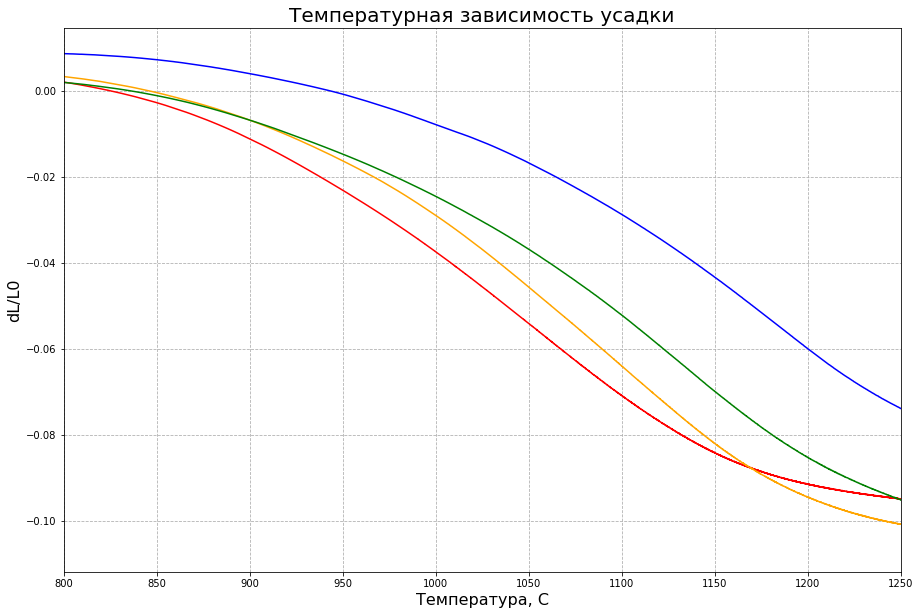

In [298]:
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(df_2['Temperature, C'],df_2['dL/L0_corr'], color='r')
ax.plot(df_5['Temperature, C'],df_5['dL/L0_corr'], color='orange')
ax.plot(df_10['Temperature, C'],df_10['dL/L0_corr'], color='green')
ax.plot(df_20['Temperature, C'],df_20['dL/L0_corr'], color='blue')
ax.set_xlim(800,1250)
ax.grid(linestyle='--')
ax.set_title('Температурная зависимость усадки', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('dL/L0',fontsize=16)
plt.show()

Отрезаем кривые после момента выхода на плато, но до расширения из-за плавления. Из-за особенностей расчета квадратичной ошибки в дальнейшем, температурный интервал для всех скоростей должен быть одинаков - 800-1250С. 

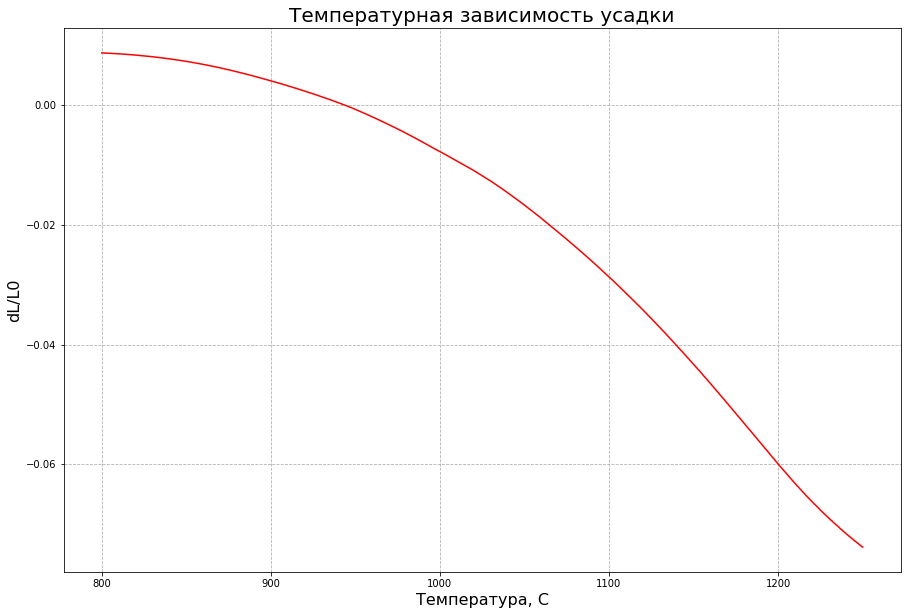

In [324]:
df_2_corr=df_2.loc[df_2.index[df_2['Temperature, C']>800][0]:df_2.index[df_2['Temperature, C']<1250][-1],:].reset_index()
df_5_corr=df_5.loc[df_5.index[df_5['Temperature, C']>800][0]:df_5.index[df_5['Temperature, C']<1250][-1],:].reset_index()
df_10_corr=df_10.loc[df_10.index[df_10['Temperature, C']>800][0]:df_10.index[df_10['Temperature, C']<1250][-1],:].reset_index()
df_20_corr=df_20.loc[df_20.index[df_20['Temperature, C']>800][0]:df_20.index[df_20['Temperature, C']<1250][-1],:].reset_index()
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(df_20_corr['Temperature, C'],df_20_corr['dL/L0_corr'], color='r')
#ax.set_xlim(0,1325)
ax.grid(linestyle='--')
ax.set_title('Температурная зависимость усадки', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('dL/L0',fontsize=16)
plt.show()

Рассчитываем итоговую плотность исходя из толщины до спекания и дилатометрической кривой (для избежания искажения из-за расширения в конце).

In [325]:
def real_density(rate, data,T):
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['h,mm'].index[0]
    h0=dens.loc[index,'h,mm']/10
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['mass, g'].index[0]
    m=dens.loc[index,'mass, g']
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['d,mm'].index[0]
    rf=dens.loc[index,'d,mm']/20
    dL=data.loc[data.index[data['Temperature, C']<T][-1],'dL/L0_corr']*1E-4
    pof=m/(np.pi*rf**2*(h0+dL))
    return pof
po_2=real_density(2, df_2,1280)
po_5=real_density(5, df_5,1270)
po_10=real_density(10, df_10,1335)
po_20=real_density(20, df_20,1325)

Рассчитываем изменение относительной плотности в процессе усадки и строим зависимость относительной плотности от температуры.

In [326]:
def rel_density_calc(data,rate):
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['density_new, g/cm^3'].index[0]
    p0=dens.loc[index,'density_new, g/cm^3']
    data['Rel Density']=((1/(1+data['dL/L0_corr']))**3)*p0/(0.6*2.822+0.4*3.12)
    return data

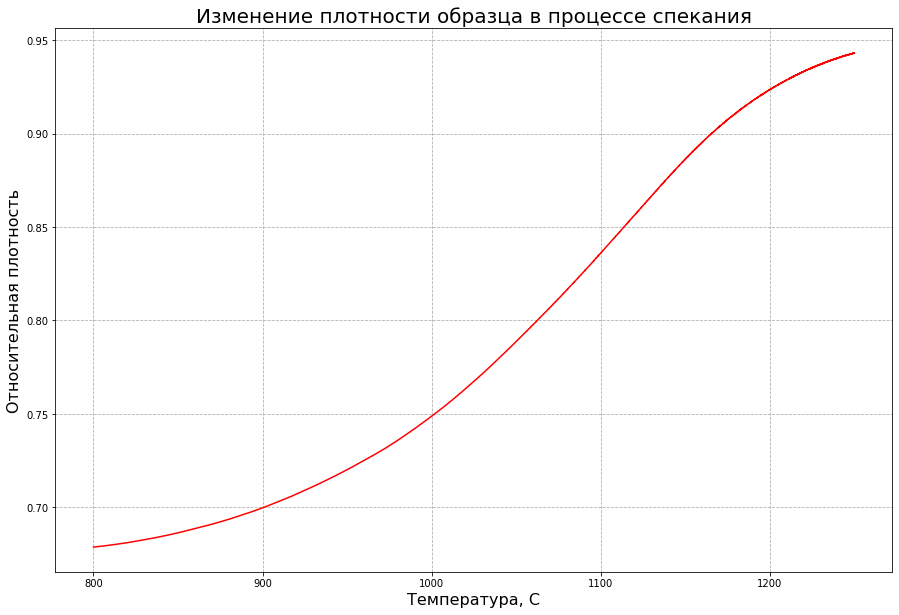

In [368]:
df_2_corr=rel_density_calc(df_2_corr,2)
df_5_corr=rel_density_calc(df_5_corr,5)
df_10_corr=rel_density_calc(df_10_corr,10)
df_20_corr=rel_density_calc(df_20_corr,20)
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(df_5_corr['Temperature, C'],df_5_corr['Rel Density'], color='r')
#ax.set_xlim(-60,0)
ax.grid(linestyle='--')
ax.set_title('Изменение плотности образца в процессе спекания', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('Относительная плотность',fontsize=16)
plt.show()

Строим зависимость плотности от работы спекания в интервале температур спекания.

10000.0


<ipython-input-328-8911ff3fb7ee>:9: RuntimeWarning: invalid value encountered in log
  logtheta_list.append(np.log(theta))
<ipython-input-328-8911ff3fb7ee>:11: RuntimeWarning: invalid value encountered in log
  logtheta_list.append(np.log(theta))


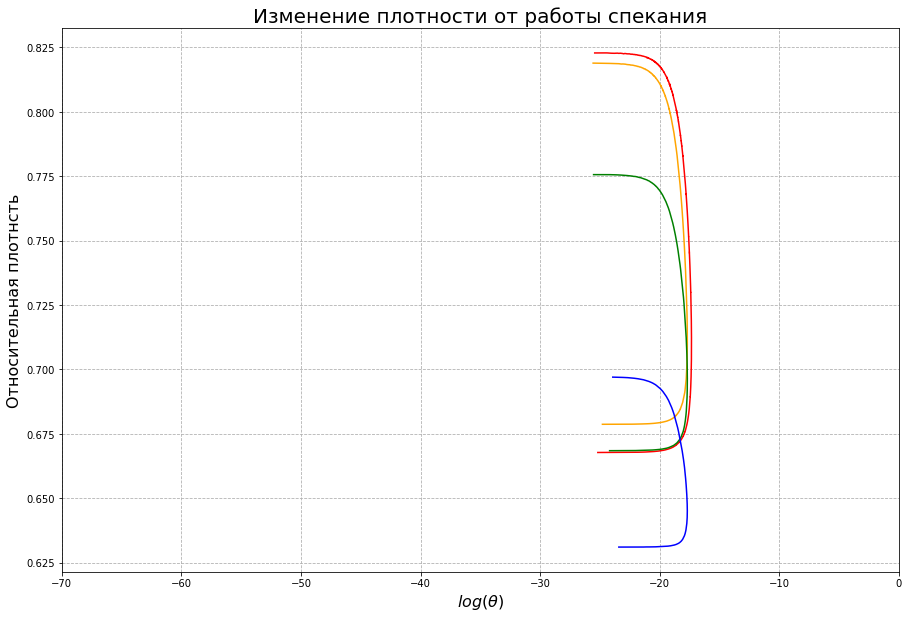

19000.0


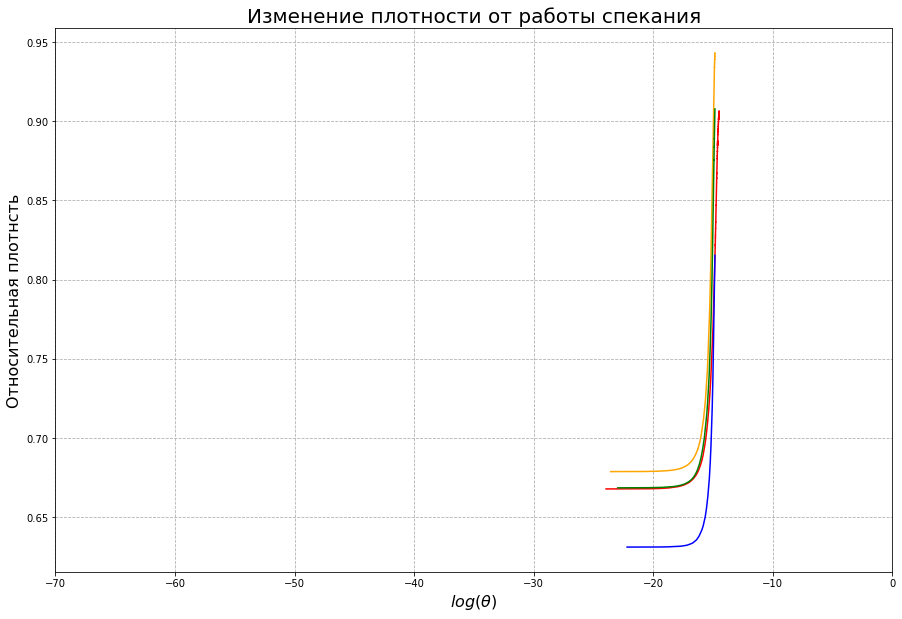

28000.0


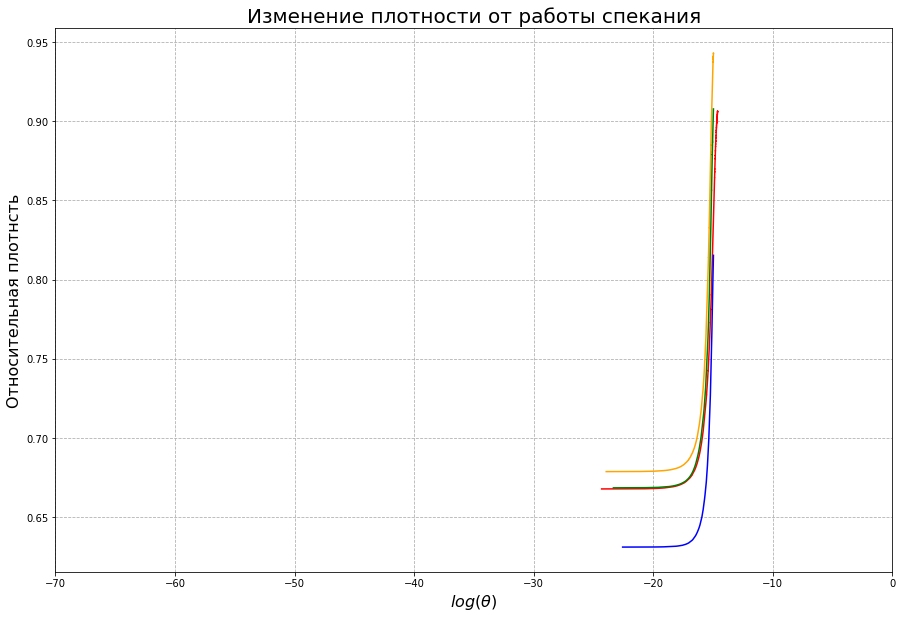

37000.0


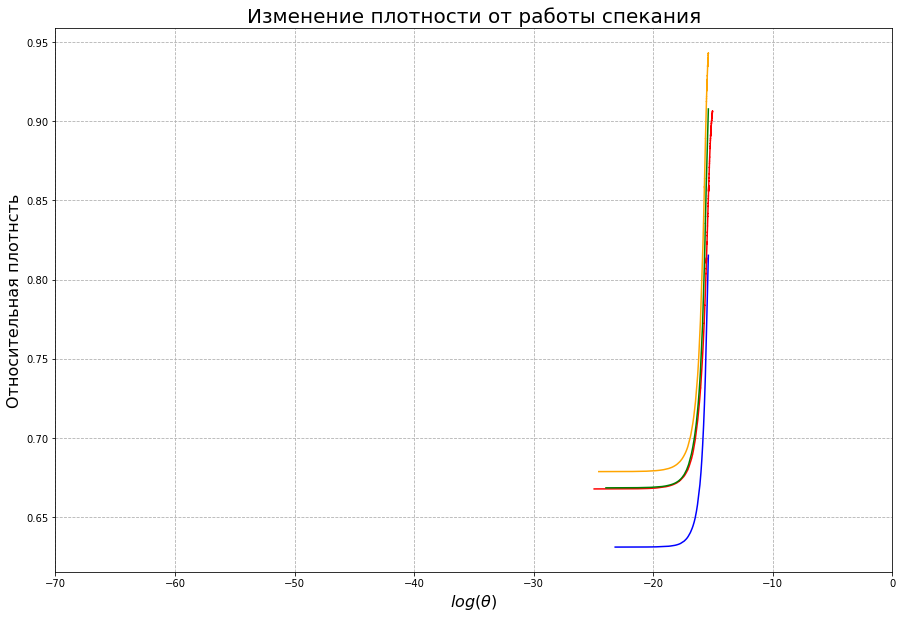

46000.0


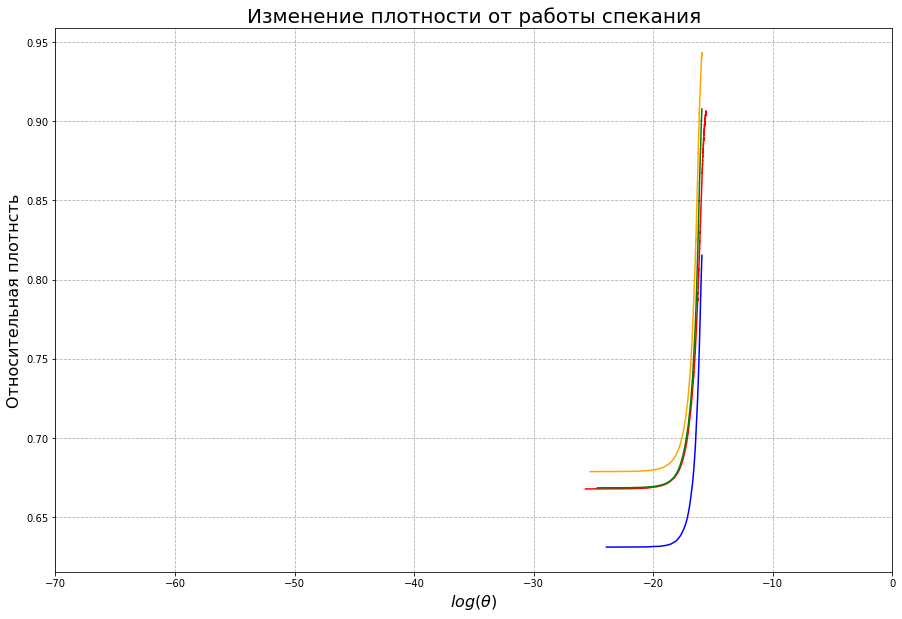

55000.0


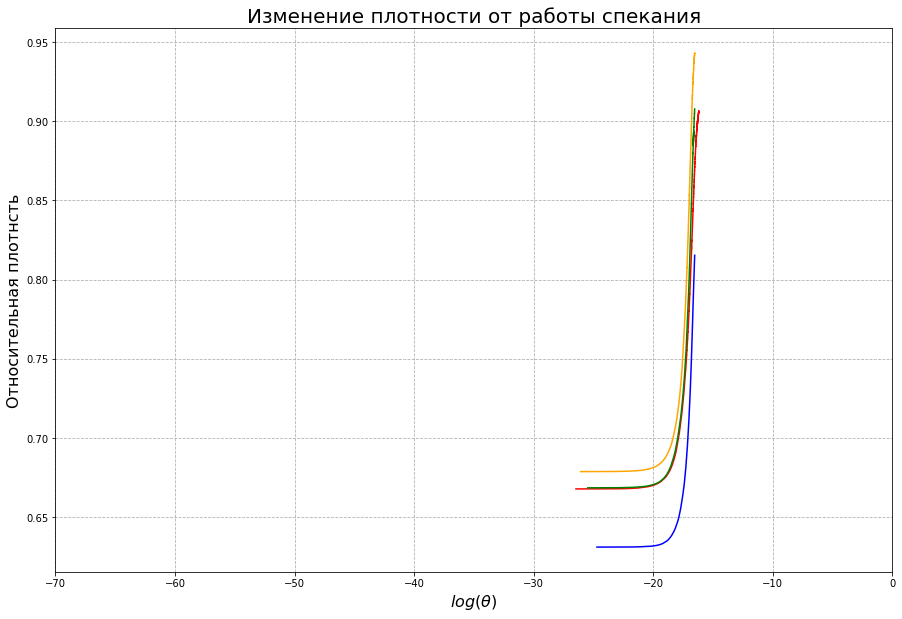

64000.0


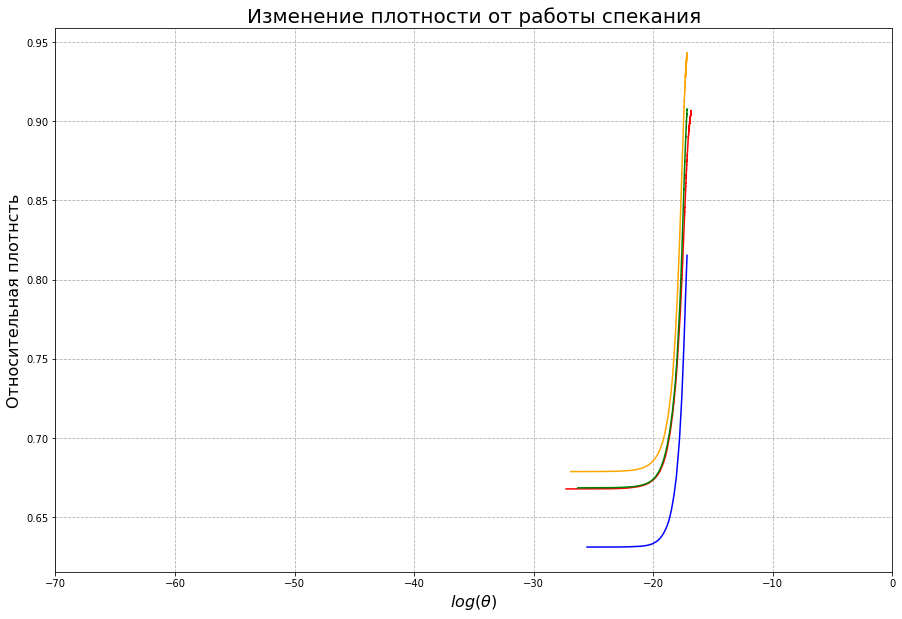

73000.0


KeyboardInterrupt: 

In [328]:
def func(data,Q):
    theta_list=[]
    logtheta_list=[]
    R=8.31
    data['Func']=(1/(data['Temperature, C']+273)*np.exp((-1)*Q/(R*(data['Temperature, C']+273))))
    theta=0
    for i in range((data.shape[0]-1)):
        theta=theta+((data.loc[i+1,'Func']-data.loc[i,'Func']))*(data.loc[i+1,'Time, min']-data.loc[i,'Time, min'])
        logtheta_list.append(np.log(theta))
        theta_list.append(theta)
    logtheta_list.append(np.log(theta))
    theta_list.append(theta)
    data['log Theta']=logtheta_list
    data['Theta']=theta_list
    return theta
Q=np.linspace(10000,100000,11)
def plot(Q):
#Q=100000
    theta_list_norm=[]
    theta_list_norm.append(func(df_2_corr,Q))
    theta_list_norm.append(func(df_5_corr,Q))
    theta_list_norm.append(func(df_10_corr,Q))
    theta_list_norm.append(func(df_20_corr,Q))
    fig,ax=plt.subplots(figsize=(15,10))
    #ax.plot(df_2_corr['Temperature, C'],df_2_corr['Func'], color='r')
    ax.plot(df_2_corr['log Theta'],df_2_corr['Rel Density'], color='r')
    ax.plot(df_5_corr['log Theta'],df_5_corr['Rel Density'], color='orange')
    ax.plot(df_10_corr['log Theta'],df_10_corr['Rel Density'], color='green')
    ax.plot(df_20_corr['log Theta'],df_20_corr['Rel Density'], color='blue')
    ax.set_xlim(-70,0)
    ax.grid(linestyle='--')
    ax.set_title('Изменение плотности от работы спекания', fontsize=20)
    ax.set_xlabel(r'$log(\theta)$',fontsize=16)
    ax.set_ylabel('Относительная плотнсть',fontsize=16)
    plt.show()
    return
for i in Q:
    print(i)
    plot(i)

In [367]:
df_2_corr

,index,"Temperature, C","Time, min",dL/L0,dL/L0_corr,Rel Density,Func,log Theta,Theta
0,26802,800.02100,379.70917,0.007469,0.002155,0.667770,2.593668e-07,-27.300843,1.391216e-12
1,26803,800.04498,379.72333,0.007463,0.002147,0.667785,2.594084e-07,-26.566392,2.899764e-12
2,26804,800.07098,379.73749,0.007458,0.002141,0.667797,2.594536e-07,-26.058270,4.819892e-12
3,26805,800.10400,379.75168,0.007448,0.002131,0.667817,2.595110e-07,-25.882097,5.748417e-12
4,26806,800.12000,379.76584,0.007455,0.002137,0.667805,2.595388e-07,-25.633054,7.374050e-12
...,...,...,...,...,...,...,...,...,...
15880,42682,1249.85803,604.67584,-0.085024,-0.094908,0.906469,2.051708e-06,-16.829145,4.911287e-08
15881,42683,1249.88794,604.69000,-0.085039,-0.094920,0.906507,2.051900e-06,-16.829064,4.911681e-08
15882,42684,1249.91296,604.70416,-0.085047,-0.094927,0.906526,2.052061e-06,-16.828965,4.912170e-08
15883,42685,1249.94397,604.71832,-0.085028,-0.094909,0.906473,2.052260e-06,-16.828872,4.912628e-08


In [378]:
str(df_2_corr)

'       index  Temperature, C  Time, min     dL/L0  dL/L0_corr  Rel Density  \\\n0      26802       800.02100  379.70917  0.007469    0.002155     0.667770   \n1      26803       800.04498  379.72333  0.007463    0.002147     0.667785   \n2      26804       800.07098  379.73749  0.007458    0.002141     0.667797   \n3      26805       800.10400  379.75168  0.007448    0.002131     0.667817   \n4      26806       800.12000  379.76584  0.007455    0.002137     0.667805   \n...      ...             ...        ...       ...         ...          ...   \n15880  42682      1249.85803  604.67584 -0.085024   -0.094908     0.906469   \n15881  42683      1249.88794  604.69000 -0.085039   -0.094920     0.906507   \n15882  42684      1249.91296  604.70416 -0.085047   -0.094927     0.906526   \n15883  42685      1249.94397  604.71832 -0.085028   -0.094909     0.906473   \n15884  42686      1249.97302  604.73248 -0.085041   -0.094918     0.906499   \n\n               Func  log Theta         Theta  \n

In [383]:
temp=np.arange(800,1250,1)
MSE_DF=pd.DataFrame(columns=['Rel Density', 'df_2_corr','df_5_corr','df_10_corr','df_20_corr'])
MSE_DF['Temperature, C']=temp
exp_data=[df_2_corr,df_5_corr,df_10_corr,df_20_corr]
def dens_theta_import(i,data):
    temperature=i
    for j in exp_data:
        dens=j.loc[j.index[j['Temperature, C']>i][0],'Rel Density']
        theta=j.loc[j.index[j['Temperature, C']>i][0],'Theta']
    return temperature, dens, theta
for i in temp:
    for j in exp_data:
        value=dens_theta_import(i,j)
        MSE_DF.loc[,:]=value
print(MSE_DF)
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(MSE_DF['Rel Density'],MSE_DF['2'], color='r')
ax.plot(MSE_DF['Rel Density'],MSE_DF['5'], color='orange')
ax.plot(MSE_DF['Rel Density'],MSE_DF['10'], color='green')
ax.plot(MSE_DF['Rel Density'],MSE_DF['20'], color='blue')
ax.grid(linestyle='--')
ax.set_title('Изменение плотности от работы спекания', fontsize=20)
ax.set_xlabel(r'$log(\theta)$',fontsize=16)
ax.set_ylabel('Относительная плотнсть',fontsize=16)
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
df_5_corr.head(20)

In [318]:
df_10_corr.iloc[::2,:].shape

(2254, 9)

In [ ]:
df_20_corr

<ipython-input-286-28beaea87c56>:8: RuntimeWarning: invalid value encountered in log
  theta_list.append(np.log(theta))
<ipython-input-286-28beaea87c56>:9: RuntimeWarning: invalid value encountered in log
  theta_list.append(np.log(theta))


Значение кажущейся энергии активации с наименьшей среднеквадратичной ошибкой:  95.0 кДж


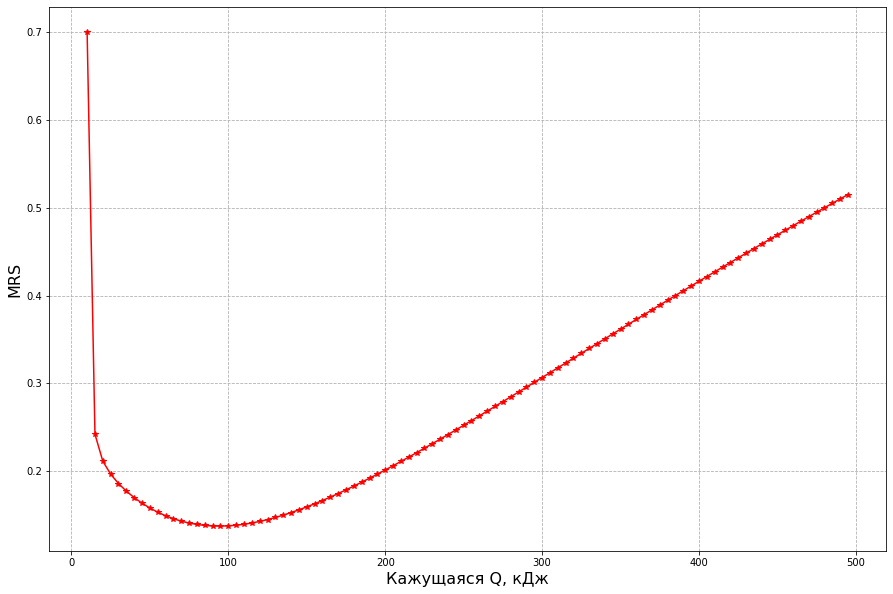

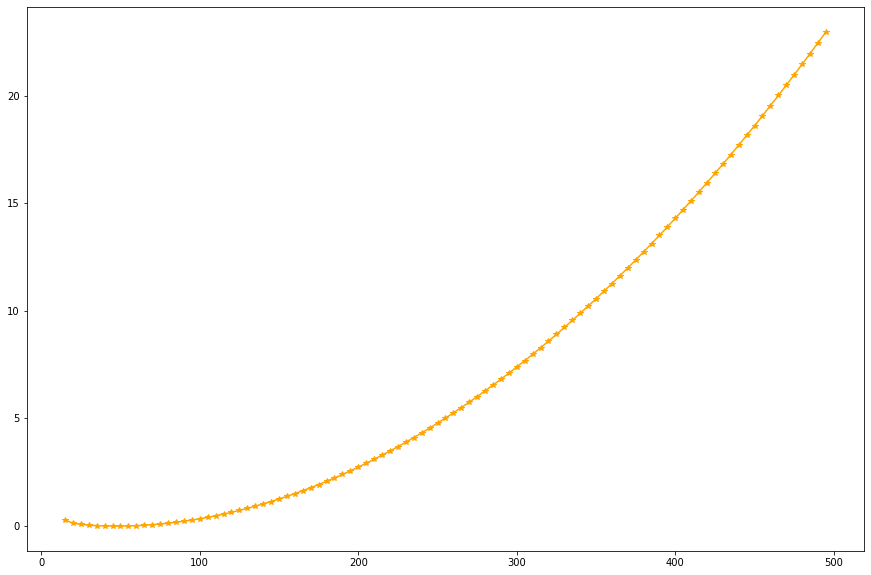

In [294]:
def f(p):
    return s/4

#Q=[25000,50000,100000,150000,200000,300000,400000,500000,600000]
Q=np.arange(10000,500000,5000)
MRS_list=[]
error_list=[]
for i in Q:
    theta_list=[]
    #df_1_corr_new=func(df_1_corr,i)
    #theta_list.append(df_1_corr_new['log Theta'].iloc[-1])
    theta_list.append(func(df_2_corr,i))
    theta_list.append(func(df_5_corr,i))
    theta_list.append(func(df_10_corr,i))
    theta_list.append(func(df_20_corr,i))
    s=0
    po_0=dens[dens['Status']=='Before sintering']['density_new, g/cm^3'].mean()
    po_f=dens[dens['Status']=='After sintering']['density_new, g/cm^3'].mean()
    for i in range(MSE_DF.shape[0]):
        
        s=s+(j/(sum(theta_list)/len(theta_list))-1)**2
    I=quad(f, po_0, po_f)
    MRS=np.sqrt((1/(po_f-po_0))*I[0])
    MRS_list.append(MRS)
    e=(df_20_corr.loc[df_20_corr.index[df_20_corr['Rel Density']<0.77][-1],'log Theta']-df_2_corr.loc[df_2_corr.index[df_2_corr['Rel Density']<0.77][-1],'log Theta'])**2
    error_list.append(e)
print('Значение кажущейся энергии активации с наименьшей среднеквадратичной ошибкой: ', Q[MRS_list.index(min(MRS_list))]/1000, 'кДж')
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(Q/1000,MRS_list, color='r',marker='*')
ax.grid(linestyle='--')
#ax.set_title('Изменение плотности от работы спекания', fontsize=20)
ax.set_xlabel('Кажущаяся Q, кДж',fontsize=16)
ax.set_ylabel('MRS',fontsize=16)
plt.show()
print('Значение кажущейся энергии активации с наименьшей среднеквадратичной ошибкой: ', Q[error_list.index(min(error_list))]/1000, 'кДж')
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(Q/1000,error_list, color='orange',marker='*')
plt.show()

In [69]:
Q=5000
error_list=[]
def theta_calc(data):
    
    return data
for i in Q:
    df_1=theta_calc(df_1, i, 3, 2.74, 7.59)
    df_2=theta_calc(df_2, i, 3, 3.14, 7.52)
    df_5=theta_calc(df_5, i, 3, 3, 7.74)
    df_10=theta_calc(df_10, i, 3, 2.98, 7.56)
    df_20=theta_calc(df_20, i, 3, 2.94, 7.55)
    e=(df_20.loc[df_20.index[df_20['Density']<3.5][-1],'Log Theta']-df_2.loc[df_2.index[df_2['Density']<3.5][-1],'Log Theta'])**2
    error_list.append(e)
    print(i,'J')
    fig,ax=plt.subplots(figsize=(15,10))
    ax.plot(df_1['Log Theta'],df_1['Density'], color='r')
    ax.plot(df_2['Log Theta'],df_2['Density'], color='orange')
    ax.plot(df_5['Log Theta'],df_5['Density'], color='yellow')
    ax.plot(df_10['Log Theta'],df_10['Density'], color='green')
    ax.plot(df_20['Log Theta'],df_20['Density'], color='b')
    ax.set_xlim(-60,0)
    ax.grid(linestyle='--')
    plt.show()
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(Q,error_list)
plt.show()

TypeError: theta_calc() takes 1 positional argument but 5 were given